### Bevægelsesligninger

Den resulterende kraft på et objekt udsat for luftmodstand i et skråt kast er

$$\vec{F_{objekt}} = m \vec{g} - \alpha | \vec{v} |^2 \cdot  \hat{\vec{v}} = m \vec{g} - \alpha | \vec{v} | \cdot  \vec{v}$$

Vi ser at kraftligningerne langs x- og y-aksen er

$$\Sigma F_x = - \alpha | \vec{v} | \cdot v_x = m a_x$$

$$\Sigma F_y = - m g - \alpha | \vec{v} | \cdot  v_y = m a_y$$

Vi dividerer med $m$ og ser at accelerationen af objektet er givet ved

$$
\vec{a} = \frac{d\vec{v}}{dt} =
\begin{bmatrix}
a_x \\
a_y \\
\end{bmatrix}
=
\begin{bmatrix}
- \frac{\alpha}{m} | \vec{v} | \cdot  v_x \\
- g - \frac{\alpha}{m} | \vec{v} | \cdot  v_y \\
\end{bmatrix}
$$


$ \vec{a} $ ændrer sig hele tiden, men for tilpas korte tidsintervaller $\Delta t$ er den tilnærmelsesvis konstant og svarer til ændringen i hastigheden over tidsintervallet. Dvs. at vi kan bruge ligningen

$$ \vec{a} = \frac{\Delta \vec{v}}{\Delta t} $$

$$ \rightarrow  \Delta \vec{v} = \vec{a} \cdot \Delta t $$

Med hensyn til ændringen i objektets position kan vi approksimere den som objektets gennemsnitshastighed over et bestemt tidsinterval ganget med tidsintervallets størrelse. Dvs. 

$$\Delta \vec{s} = \vec{v}_{gns} \cdot \Delta t $$

Gennemsnitshastigheden bliver

$$ \frac{(\vec{v} + (\vec{v} + \Delta \vec{v}))}{2} = \\
(\vec{v} + \frac{\Delta \vec{v}}{2})$$

Eftersom $\vec{v}$ er hastigheden i starten af tidsintervallet og $\vec{v} + \Delta \vec{v}$ er hastigheden i slutningen af tidsintervallet.

Altså må ændringen i positionen være givet ved

$$\Delta \vec{s} = (\vec{v} + \frac{\Delta \vec{v}}{2}) \cdot \Delta t $$

$$ = \vec{v} \cdot \Delta t + \frac{\Delta \vec{v} \cdot \Delta t}{2} $$

$$ = \vec{v} \cdot \Delta t + \frac{\vec{a} \cdot {\Delta t}^2}{2} $$

Nu hvor vi har fundet udtryk for $\Delta \vec{v}$ og $\Delta \vec{s}$ kan vi til ethvert tidspunkt i vores simulation beregne den næste position og hastighed, idet 

$$\vec{v_n} = \vec{v}_{n-1} + \Delta \vec{v}$$
$$\vec{s_n} = \vec{s}_{n-1} + \Delta \vec{s}$$

### Implementering

Nu er vi klar til at implementere simulationen. Vi starter med nogle begyndelsesbetingelser og laver en løkke der løbende opdaterer objektets position og hastighed indtil det rammer jorden.

Vi kan lave alle de plots vores hjerte begærer *inde i funktionen*, så slipper vi for at skulle returnere en masse lister med data ;)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown as md, display_markdown

# Hjælpefunktion fordi jeg er doven
def vectorlen(vector):
    return np.linalg.norm(vector)

# Tager s_0 som et array eller en tuple [x, y]
def simulate_throw(alpha, g, m, v_0, s_0, theta_0, Delta_t):
    # Startbetingelser
    s = np.array(s_0)
    v = v_0 * np.array([np.cos(theta_0), np.sin(theta_0)])
    a = np.array([0,0])

    # For at gemme objektets bevægelse i løbet af simulationen
    x_arr = []
    y_arr = []

    # Kør simulationen indtil objektet rammer jorden (indtil y <= 0)
    while (s[1] > 0):
        # Udregn accelerationen
        a[0] = -(alpha/m)*vectorlen(v)*v[0]
        a[1] = -g -(alpha/m)*vectorlen(v)*v[1]

        # Udregn hastighedsændring
        v = v + a * Delta_t
        
        # Udregn positionsændring
        s = s + v * Delta_t + (a * Delta_t**2)/2

        # Gem position
        x_arr.append(s[0])
        y_arr.append(s[1])

    # Skudlængde
    l = x_arr[-1]

    # Plot objektets bevægelse
    plt.figure(1)
    plt.grid()
    plt.title("Plot af objektets bevægelse")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(x_arr, y_arr)
    plt.xlim(0, l + 0.5)
    plt.ylim(0, l + 0.5)

    # Returner skudlængden
    return l



Vi kører simulationen for $\theta_0 = \frac{\pi}{4} $

Skudlængden for $\theta_0 = \frac{\pi}{4} $ er 1.90133

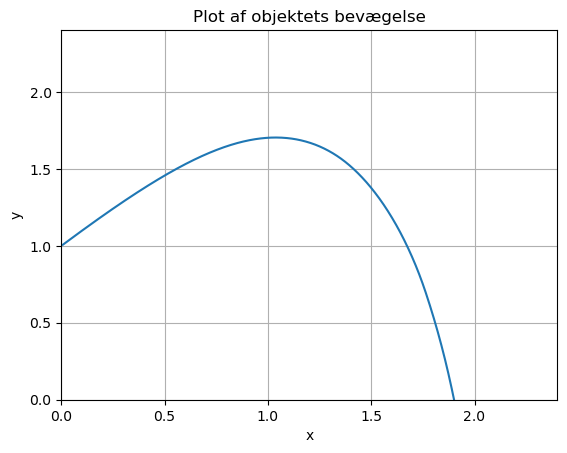

In [8]:
length = simulate_throw(alpha=0.1, g=10, m=0.1, v_0=10, s_0=[0, 1], theta_0=(np.pi/4), Delta_t=0.001)

display_markdown(md(r"Skudlængden for $\theta_0 = \frac{{\pi}}{{4}} $ er {:.5f}".format(length)))


Nu er tiden kommet til at finde vinklen der fører til den størst mulige skudlængde. Vi får at vide at vi skal teste mindst 50 forskellige vinkler. Lad os bruge rekursion :D

Vi laver en funktion der tager to vinkler og leder efter vinklen med størst skudlængde inden for intervallet mellem dem.

Først genererer vi 50 jævnt fordelte vinkler i intervallet og ser på skudlængden for hver af dem. Derefter tager vi vinklen med størst skudlængde og gentager processen for intervallet udgjort af vinklen før og efter denne vinkel.

Vi skal selvfølgelig stoppe rekursionen på et tidspunkt, så vi vælger at stoppe når skudlængden kun ændrer sig efter et bestemt decimal, anført med "precision"-parametren.

For precision=5 vil funktion f.eks. fortsætte med at lede efter skudlængder indtil skudlængden ikke ændrer sig på de første 5 decimaler efter kommaet.

Vinklen med størst skudlængde er 0.394 radianer med en skudlængde på 2.094


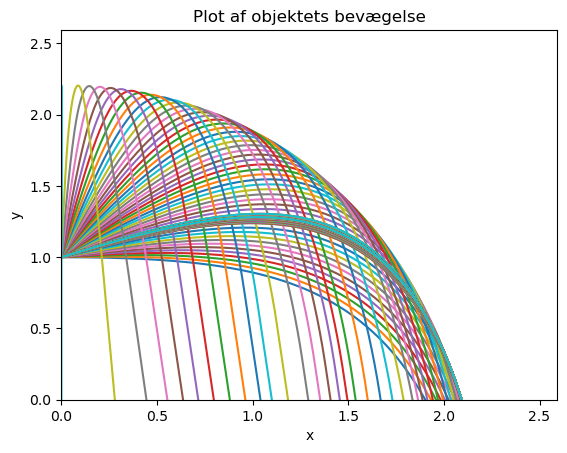

In [9]:
def findOptimalAngle(start, end, precision, angle_Delta_t, prev_max_length=0):
    # Generer 50 jævnt fordelte vinkler i intervallet
    angles = np.linspace(start, end, 50)

    # Gemmer indeks og skudlængde for vinklen med størst skudlængde
    # [vinkelindeks, skudlængde]
    res = []

    # Løkke der kører igennem de genererede vinkler
    for i in range(angles.size):
        # Skudlængde for den i'te vinkel
        length = simulate_throw(alpha=0.1, g=10, m=0.1, v_0=10, s_0=[0, 1], theta_0=angles[i], Delta_t=angle_Delta_t)

        # Hvis det er den første vinkel vi tjekker gemmes den
        if len(res) == 0:
            res = [i, length]
        # Ellers tjekker vi om den nuværende vinkel giver en større skudlængde end det forrige maks
        elif res[1] <= length:
            res = [i, length]

    # Vi stopper hvis skudlængden ikke ændrer sig mere
    if round(res[1], precision) == round(prev_max_length, precision):
        # Returner vinklen og skudlængden (afrundet til det valgte antal decimaler)
        return (round(angles[res[0]], precision), round(res[1], precision))
    
    # Her vælges det nye interval (v er vinklen med størst skudlængde i det gamle interval)

    # Hvis v er i enden af intervallet vi kiggede på
    # lader vi v være den nederste vinkel i det nye interval
    if res[0] == len(angles) - 1:
        start = angles[res[0] - 1]
        end = angles[res[0]]
    # I det omvendte tilfælde hvor v er den første vinkel i intervallet vi kiggede på
    # lader vi v være den øverste vinkel i det nye interval
    elif res[0] == 0:
        start = angles[res[0]]
        end = angles[res[0] + 1]
    # Ellers er det nye interval [v - 1, v + 1] hvor v - 1 og v + 1 er vinklerne før og efter v
    else:
        start = angles[res[0] - 1]
        end = angles[res[0] + 1]

    # Hvis vi ikke har fundet den bedste skudlængde endnu fortsætter vi
    return findOptimalAngle(start, end, precision, angle_Delta_t, res[1])
        
# Kald funktionen med startintervallet 0° til 90°
optimal_angle, optimal_length = findOptimalAngle(start=0, end=np.pi/2, precision=3, angle_Delta_t=0.001)

print("Vinklen med størst skudlængde er {} radianer med en skudlængde på {}".format(optimal_angle, optimal_length))

Det ser ret fedt ud med plottet af de mange baner, så jeg lader det bare stå.